# Import

In [11]:
import pandas as pd
from gtfparse import read_gtf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import matplotlib.ticker as ticker
from collections import defaultdict
from bx.intervals import Interval, IntervalTree


In [6]:
# Set the settings for plotting the figures
rc = {'figure.figsize':(15,10),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20,    
      'font.sans-serif': 'Arial',
      'font.family': 'sans-serif',
      'svg.fonttype' : 'none' }


# B. Isoform classification

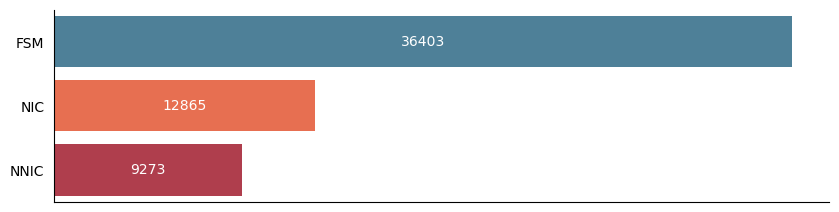

In [7]:

# Load the IsoQuant classification
isoforms = pd.read_csv('data/transcriptomics/isoquant_classification.tsv', sep = '\t')

# Set the figure size
rc = {'figure.figsize':(10,2.5)}
plt.rcParams.update(rc)

# Create the barplot
p = sns.barplot(x=isoforms.structural_category.value_counts().values, y=['FSM', 'NIC', 'NNIC'], palette=['#4E8098', '#E76F51', '#AF3E4D'], saturation=1)
#p.set(ylabel='Transcript classification')
p.get_xaxis().set_visible(False)
# Add data label
p.bar_label(p.containers[0], label_type='center', color = 'white')
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
# Remove x and y ticks
p.tick_params(left=False)
plt.savefig('plots/transcript_classification.svg', dpi=300, bbox_inches="tight")

# B. Read classification

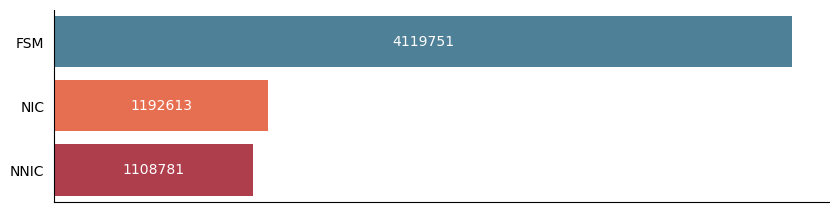

In [8]:
# Load the reads
reads = pd.read_csv('data/transcriptomics/isoquant_aln.sorted.transcript_model_reads.tsv', sep = '\t')

# Add a structural category to each read
structural_category = []
for id in reads['transcript_id']:
    if 'ENST' in id:
        structural_category.append('FSM')
    elif id == '*':
        structural_category.append('None')
    else:
        structural_category.append(id.split('.')[2])
reads['structural_category'] = structural_category
reads = reads[reads['structural_category'] != 'None']

# Set the figure size
rc = {'figure.figsize':(10,2.5)}
plt.rcParams.update(rc)

# Create the barplot
p = sns.barplot(x=reads.structural_category.value_counts().values, y=['FSM', 'NIC', 'NNIC'], palette=['#4E8098', '#E76F51', '#AF3E4D'], saturation=1)
# Add data label
p.bar_label(p.containers[0], label_type='center', color = 'white', fmt='%d')
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
p.get_xaxis().set_visible(False)
# Remove x and y ticks
p.tick_params(left=False)
plt.savefig('plots/read_classification.svg', dpi=300, bbox_inches="tight")

# C. Distance to nearest CAGE peak

In [12]:
# Copied from SQANTI3
class CAGEPeak:
    def __init__(self, cage_bed_filename):
        self.cage_bed_filename = cage_bed_filename
        self.cage_peaks = defaultdict(lambda: IntervalTree()) # (chrom,strand) --> intervals of peaks

        self.read_bed()

    def read_bed(self):
        for line in open(self.cage_bed_filename):
            raw = line.strip().split()
            chrom = raw[0]
            start0 = int(raw[1])
            end1 = int(raw[2])
            strand = raw[5]
            tss0 = int((start0+end1)/2)
            self.cage_peaks[(chrom,strand)].insert(start0, end1, (tss0, start0, end1))

    def find(self, chrom, strand, query, search_window=10000):
        """
        :param start0: 0-based start of the 5' end to query
        :return: <True/False falls within a cage peak>, <nearest dist to TSS>
        dist to TSS is 0 if right on spot
        dist to TSS is + if downstream, - if upstream (watch for strand!!!)
        """
        within_peak, dist_peak = 'FALSE', 'NA'
        for (tss0,start0,end1) in self.cage_peaks[(chrom,strand)].find(query-search_window, query+search_window):
 # Skip those cage peaks that are downstream the detected TSS because degradation just make the transcript shorter
            if strand=='+' and start0>int(query) and end1>int(query):
                continue
            if strand=='-' and start0<int(query) and end1<int(query):
                continue
##
            within_out = (start0<=query<end1)
            if within_out:
                w = 'TRUE'
            else:
                w = 'FALSE'

            if not within_peak=='TRUE':
                within_peak, dist_peak = w, (query - tss0) * (-1 if strand=='-' else +1)
            else:
                d = (query - tss0) * (-1 if strand=='-' else +1)
                if abs(d) < abs(dist_peak):
                    within_peak, dist_peak = w, d
        return within_peak, dist_peak

In [17]:
# read in the CAGEPeak file
cage_peak_obj = CAGEPeak('data/transcriptomics/human.refTSS_v3.1.hg38.bed')

# Load Isoquant data
# Read isoquant gtf file
isoquant_gtf = read_gtf('data/transcriptomics/isoquant_aln.sorted.transcript_models.gtf')
transcripts = isoquant_gtf[isoquant_gtf['feature'] == 'transcript']

transcripts['within_CAGE'] = np.nan
transcripts['dist_CAGE'] = np.nan

for index,row in transcripts.iterrows():
    # look at Cage Peak info 
    if row.strand == '+':
        within_CAGE, dist_CAGE = cage_peak_obj.find(row.seqname, row.strand, row.start)
    else:
        within_CAGE, dist_CAGE = cage_peak_obj.find(row.seqname, row.strand, row.end)
    row.within_CAGE = within_CAGE
    row.dist_CAGE = dist_CAGE

    transcripts.loc[index,:] = row

with_cage = transcripts[transcripts.within_CAGE == 'TRUE']

known_with_cage = with_cage[with_cage.transcript_id.str.contains('ENST')]
novel_with_cage = with_cage[with_cage.transcript_id.str.contains('transcript')]
with_cage.dist_CAGE = with_cage.dist_CAGE.astype('int')


# Add a structural category column
with_cage['transcript_class'] = np.nan

for index,row in with_cage.iterrows():
    if row.transcript_id.startswith('ENST'):
        row['transcript_class'] = 'known'
    else:
        row['transcript_class'] = 'novel'

    with_cage.loc[index,:] = row


# Set the figure size
rc = {'figure.figsize':(7,7)}
plt.rcParams.update(rc)

# Create the histogram
known_heights, known_bins = np.histogram(known_with_cage['dist_CAGE'], density = True)
novel_heights, novel_bins = np.histogram(novel_with_cage['dist_CAGE'], bins=known_bins, density = True)
width = (known_bins[1] - known_bins[0])/3

known_percent = [i/sum(known_heights)*100 for i in known_heights]
novel_percent = [i/sum(novel_heights)*100 for i in novel_heights]


fig, ax = plt.subplots()
ax.bar(known_bins[:-1], known_percent, width=width, facecolor='#4E8098')
ax.bar(novel_bins[:-1]+width, novel_percent, width=width, facecolor='#cb564f')
ax.legend(['GENCODE', 'novel'], loc='upper center')
vals = ax.get_yticks()
ax.set(xlabel='Distance to FANTOM5 CAGE Peak (bp)')
ax.set(ylabel='Isoforms')
ax.set_yticklabels(['%1.0f%%' %i for i in vals])
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
plt.savefig('plots/CAGE_peak.svg', dpi=300, bbox_inches='tight')
plt.show()


# Print statistics about CAGE support
# Number of transcripts with CAGE support
print(('{} transcripts have CAGE support').format(len(with_cage)))

# Number of novel transcripts with CAGE support
print(('{} ({}) known transcripts have CAGE support').format(len(known_with_cage), len(known_with_cage)/(len(transcripts[transcripts.transcript_id.str.contains('ENST')]))))

# Number of novel transcripts with CAGE support
print(('{} ({}) novel transcripts have CAGE support').format(len(novel_with_cage),len(novel_with_cage)/ (len(transcripts[transcripts.transcript_id.str.contains('transcript')]))))

# Number of nic transcripts with CAGE support
nic_with_cage = with_cage[with_cage.transcript_id.str.endswith('.nic')]
print(('{} ({}) nic transcripts have CAGE support').format(len(nic_with_cage),len(nic_with_cage)/ (len(transcripts[transcripts.transcript_id.str.endswith('.nic')]))))

# Number of nnic transcripts with CAGE support
nnic_with_cage = with_cage[with_cage.transcript_id.str.endswith('.nnic')]
print(('{} ({}) nnic transcripts have CAGE support').format(len(nnic_with_cage),len(nnic_with_cage)/ (len(transcripts[transcripts.transcript_id.str.endswith('.nnic')]))))

/home/tabear/anaconda3/envs/plots/lib/python3.11/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home/tabear/anaconda3/envs/plots/lib/python3.11/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(


# Novelty of isoforms

/tmp/ipykernel_531909/3415102111.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novel['alternatives'] = novel.subcategory.str.split(',')


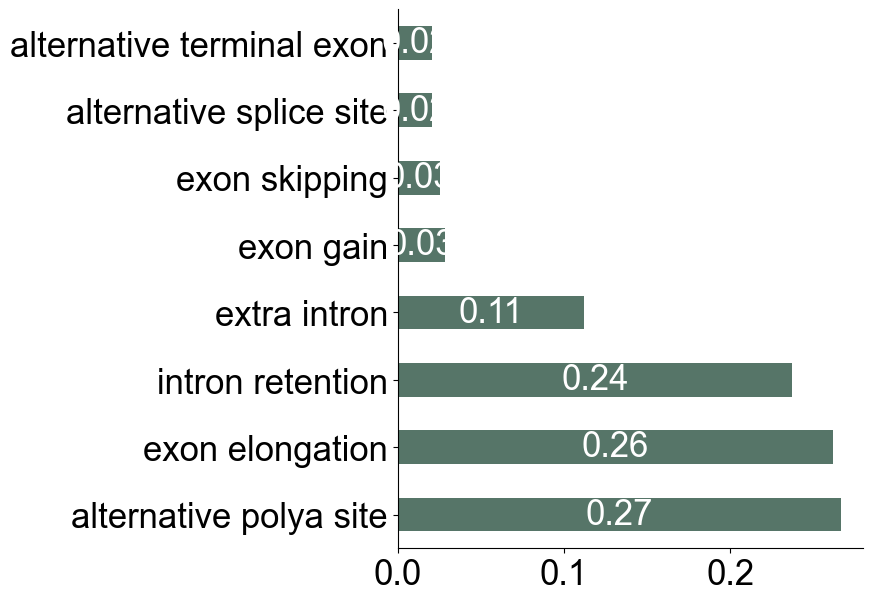

In [ ]:
# Select novel isoforms
novel = isoforms[isoforms['subcategory'].notna()]
novel['alternatives'] = novel.subcategory.str.split(',')
novel = novel.explode('alternatives')
novel=novel[novel.alternatives.str.contains(':')]
novel['alternatives']=novel.alternatives.apply(lambda x: x.split(':')[0])
novel = novel[novel['alternatives'].str.contains('known') == False]
novel = novel[novel['alternatives'].str.contains('correct') == False]
novel = novel[novel['alternatives'].str.contains('alternative_structure_novel') == False]
# Group similar terms together
d = {'alternative_polya_site_left': 'alternative polya site', 'alternative_polya_site_right': 'alternative polya site',
     'exon_elongation_5' : 'exon elongation', 'major_exon_elongation_5' : 'exon elongation', 'major_exon_elongation_3' : 'exon elongation', 'exon_elongation_3': 'exon elongation', 
     'intron_retention' : 'intron retention', 'incomplete_intron_retention_3' : 'intron retention', 'incomplete_intron_retention_5' : 'intron retention',
     'extra_intron_5' : 'extra intron', 'extra_intron_3' : 'extra intron', 'extra_intron_novel' : 'extra intron',
     'terminal_exon_shit_novel' : 'alternative terminal exon',
     'exon_gain_novel' : 'exon gain',
     'exon_skipping_novel': 'exon skipping',
     'terminal_exon_shift_novel': 'alternative terminal exon',
     'intron_shift' : 'shifted intron (misalignment)',
     'alt_donor_site_novel' : 'alternative splice site', 'alt_acceptor_site_novel' : 'alternative splice site'
     }
novel = novel.replace({'alternatives': d})

# Create the barplot
p = novel.alternatives.value_counts(normalize=True).head(8).plot.barh(figsize=(6,7),color=['#567568'])
# Remove black x and y axis line
sns.despine(bottom = False, left = False)
# Add data label
p.bar_label(p.containers[0], label_type='center', color = 'white', fmt='%.2f')
plt.savefig('plots/transcript_novelty.svg' , dpi=300, bbox_inches="tight")
plt.show()